In [1]:
from __future__ import print_function

import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

save_dir = os.path.join(os.getcwd(), 'saved_models')

from IPython.display import clear_output
from keras_helper import PlotProgress

%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 6

In [3]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entity='loss'):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="{}".format(self.entity))
        plt.plot(self.x, self.val_losses, label="val_{}".format(self.entity))
        plt.legend()
        plt.show();

In [4]:
body_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_x_train.txt', sep='\s+', header=None)
body_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_y_train.txt', sep='\s+', header=None)
body_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_acc_z_train.txt', sep='\s+', header=None)

total_acc_x_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_x_train.txt', sep='\s+', header=None)
total_acc_y_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_y_train.txt', sep='\s+', header=None)
total_acc_z_train = pd.read_csv('../data/har/train/Inertial_Signals/total_acc_z_train.txt', sep='\s+', header=None)

body_gyro_x_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_x_train.txt', sep='\s+', header=None)
body_gyro_y_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_y_train.txt', sep='\s+', header=None)
body_gyro_z_train = pd.read_csv('../data/har/train/Inertial_Signals/body_gyro_z_train.txt', sep='\s+', header=None)

y_train = pd.read_csv('../data/har/train/y_train.txt', sep='\s+', header=None).values

In [6]:
label_info = pd.read_csv('../data/har/activity_labels.txt', sep='\s+', header=None)
label_mapping = dict()

for index, row_data in label_info.iterrows():
    label_mapping.update({row_data[0] -1 : row_data[1]})

In [5]:
def get_spectogram(x):
    frequencies, times, spectogram = signal.spectrogram(
        x,
        fs = 50,
        window = 'boxcar',
        nperseg = 32,
        noverlap = 16,
    )
    return spectogram
    
spects_list = [body_acc_train.apply(get_spectogram, axis=1) for body_acc_train in 
                              [body_acc_x_train, body_acc_y_train, body_acc_z_train,
                               total_acc_x_train, total_acc_y_train, total_acc_z_train,
                               body_gyro_x_train, body_gyro_y_train, body_gyro_z_train,]]

In [7]:
X_train = np.stack([np.array([elem for elem in component.values]) for component in spects_list], axis=-1)

In [8]:
encoder = OneHotEncoder(categories='auto')
Y_train = encoder.fit_transform(y_train).toarray()

In [9]:
X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

In [11]:
kernel_shape = (3, 3)
max_pool_shape = (2, 2)
rate = 0.25

input_sample_size = X_train.shape[1:]

model = Sequential()
model.add(Conv2D(64, kernel_shape, padding='same',
                 input_shape=input_sample_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = max_pool_shape, strides=1, padding='same'))
model.add(Dropout(rate))

model.add(Conv2D(32, kernel_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = max_pool_shape, strides=1, padding='same'))
model.add(Dropout(rate))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(rate))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
kernel_shape = (3, 3)
max_pool_shape = (2, 2)
rate = 0.25

input_sample_size = X_train.shape[1:]

model = Sequential()
model.add(Conv2D(16, kernel_shape, padding='same',
                 input_shape=input_sample_size))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = max_pool_shape, strides=1, padding='same'))
# model.add(Dropout(rate))

# model.add(Conv2D(32, kernel_shape, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = max_pool_shape, strides=1, padding='same'))
# model.add(Dropout(rate))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(rate))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(rate))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 17, 7, 64)         5248      
_________________________________________________________________
activation_5 (Activation)    (None, 17, 7, 64)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 7, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 17, 7, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 7, 32)         18464     
_________________________________________________________________
activation_6 (Activation)    (None, 17, 7, 32)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 7, 32)         0         
__________

In [13]:
opt = keras.optimizers.rmsprop(lr=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [14]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                      Y_train,
                                                      test_size=0.2,
                                                      random_state=123)

In [15]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((5881, 17, 7, 9), (5881, 6), (1471, 17, 7, 9), (1471, 6))

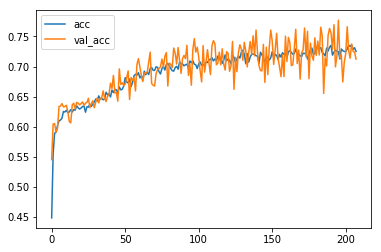

Epoch 209/400
3200/5881 [===============>..............] - ETA: 3s - loss: 0.5272 - acc: 0.7259
Output saved to: "./keras-saves/_latest.ckpt./*"
CPU times: user 36min 7s, sys: 5min, total: 41min 8s
Wall time: 19min 24s


In [16]:
%%time
batch_size = 64
epochs = 400

plot_progress = PlotProgress(entity='acc')

save_path = './keras-saves/_latest.ckpt'
try:
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_valid, Y_valid),
              callbacks=[plot_progress],
              shuffle=True,
         )
except KeyboardInterrupt:
#     model.save(save_path)
    print('\nOutput saved to: "{}./*"'.format(save_path))

In [ ]:
layer_name = 'conv2d_1'

In [ ]:
import conv_filter_visualization as filter_viz

In [ ]:
from importlib import reload
reload(filter_viz)

In [ ]:
filter_viz.visualize_layer(model, layer_name)

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
def get_confusion_matrix(Y, Y_hat):
    report = classification_report(
        y_true=Y.argmax(axis=1),
        y_pred=Y_hat.argmax(axis=1),
        labels=list(label_mapping.keys()),
        target_names=list(label_mapping.values())
    )
    return report

In [ ]:
print("Train Confusion Matrix\n", get_confusion_matrix(Y_train, model.predict(X_train)))
print("Validation Confusion Matrix\n", get_confusion_matrix(Y_valid, model.predict(X_valid)))

In [ ]:
spects = body_gyro_z_train.apply(lambda x :
    signal.spectrogram(
            x,
            fs = 50,
            window = 'boxcar',
            nperseg = 32,
            noverlap = 8,
        )
    , axis = 1
)

In [ ]:
grouped_mean_spectrogram = spects.groupby(y_train.reshape(-1)).apply(lambda group: np.mean([specg for frequencies, times, specg in group], axis=0))

In [ ]:
plt.figure(figsize=(10, 10))
for i in grouped_mean_spectrogram.index:
    plt.subplot(2, 3, i)
#     plt.yticks(frequencies)
    plt.imshow(grouped_mean_spectrogram[i], cmap='plasma')
    plt.title(label_mapping.get(i-1))

In [ ]:
plt.figure(figsize=(20, 20))

sample = 10
cat = 4

for i, (freqs, times, spec) in enumerate(spects.groupby(y_train.reshape(-1)).get_group(cat)[:sample]):
    plt.subplot(3, 4, i+1)
    plt.yticks(freqs)
    plt.imshow(spec, cmap='plasma')
    plt.title(label_mapping.get(cat))
